<a href="https://colab.research.google.com/github/vinayprabhu/hate_scaling/blob/main/code/3_nsfw_400M_2Ben.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOAL: 

The goal of this notebook is to better understand the nexus b/w the image-based NSFW classifier supplied with the dataset and the alt-text based QUALITY classifier derived using the Pysentimiento model

# 1: Standard imports (This is my customized default first-cell)

In [1]:
from psutil import virtual_memory
# Make sure to run it on a high-memory instance
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
%matplotlib inline

from scipy.linalg import block_diag
import seaborn as sns
# Numpy aesthetics
np.set_printoptions(suppress=True)
from collections import Counter
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import itertools
%precision 6
#############################################
import sys
import importlib
importlib.reload(sys)
import pyarrow.parquet as pq
#######################
from google.colab import drive
drive.flush_and_unmount()
import os
drive.mount('/gdrive', force_remount=True)
# Enter your own proj_dir here
proj_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset/'
os.chdir(proj_dir)

Your runtime has 54.8 gigabytes of available RAM



<ipython-input-1-eaf6a42be3b6>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Mounted at /gdrive


# Download the LAION datasets

Source: https://laion.ai/laion-400-open-dataset/


*We produced the dataset in several formats to address the various use cases*: 
- A 50GB url+caption metadata dataset in parquet files. This can be used to compute statistics and redownload part of the dataset
- A 10TB webdataset with 256×256 images, captions and metadata. This is a full version of the dataset, that can be used directly for training
- A 1TB set of the 400M text and image clip embeddings, useful to rebuild new knn indices
- Two 4GB knn indices allowing to easily search in the dataset + two higher quality 16GB knn indices (running in the webdemo)
URL and caption metadata dataset.

We provide 32 parquet files of size around 1GB (total 50GB) with the image URLs, the associated texts and additional metadata in the following format:

SAMPLE_ID | URL | TEXT | LICENSE | NSFW | similarity | WIDTH | HEIGHT

where

- SAMPLE_ID:   A unique identifier
LICENSE:   If a Creative Commons License could be extracted from the image data, we name it here like e.g. “creativecommons.org/licenses/by-nc-sa/3.0/” – otherwise you’ll find it here a “?”
- NSFW: CLIP had been used to estimate if the image has NSFW content. The estimation has been pretty conservative, reducing the number of false negatives at the cost of more false positives. Possible values are “UNLIKELY”, “UNSURE” and “NSFW”
- similarity: Value of the cosine similarity between the text and image embedding
- WIDTH and HEIGHT: image size as the image was embedded. Originals that were larger than 4K size were resized to 4K

*This metadata dataset is best used to redownload the whole dataset or a subset of it. The img2dataset tool can be used to efficiently download such subsets*.

Source of the parquet files:
https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/


```
!wget http://3080.rom1504.fr/cah/cah_dataframe_unique/part-00000-4d76554c-2d66-4112-9420-0bb9d725a79d-c000.snappy.parquet
!wget https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
!wget -m -np -c -U "eye02" -w 2 -R "index.html*" "https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/"

# LAION-2B-En
!git lfs install
!git clone https://huggingface.co/datasets/laion/laion2B-en
```



After downloading the datasets, your dir-tree should look like:
```
the-eye.eu
├── robots.txt
└── public
    └── AI
        └── cah
            └── laion400m-met-release
                ├── laion400m-meta
                │   ├── part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00001-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00002-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00004-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet

```
```
LAION-2Ben
├── laion2B-en
│   ├── .git
│   ├── .gitattributes
│   ├── README.md
│   ├── part-00026-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00056-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00033-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00074-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00019-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00016-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00053-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00099-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00035-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00067-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00098-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00013-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00049-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00073-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00079-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00017-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
```
Here's the helper func to generate these:

# 2: Data acquaintance:
Let us take a look at the individual parquet files constituting these datasets:

- LAION-400M is split into 32 parquet files
- LAION-2B-En has 128 parquet files

In [2]:
# parquet_list=[]
# import os
# for root, dirs, files in os.walk(os.getcwd()):
#     for file in files:
#         if file.endswith(".snappy.parquet"):
#              parquet_list.append(os.path.join(root, file))
# len(parquet_list)
# This list has been saved in a nice readable dataframe that you can simply load:
data_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset' # This will vary based on your env
df_parquet=pd.read_csv('df_parquet_400m_2b.csv')
df_parquet

,dataset,file_id,file_size_GB,file_loc
0,400m,400m_0,1.6794,./the-eye.eu/public/AI/cah/laion400m-met-relea...
1,400m,400m_1,1.6800,./the-eye.eu/public/AI/cah/laion400m-met-relea...
2,400m,400m_2,1.6792,./the-eye.eu/public/AI/cah/laion400m-met-relea...
3,400m,400m_3,1.6797,./the-eye.eu/public/AI/cah/laion400m-met-relea...
4,400m,400m_4,1.6797,./the-eye.eu/public/AI/cah/laion400m-met-relea...
...,...,...,...,...
155,2B,2B_123,2.5123,./LAION-2Ben/laion2B-en/part-00122-5114fd87-29...
156,2B,2B_124,2.5122,./LAION-2Ben/laion2B-en/part-00104-5114fd87-29...
157,2B,2B_125,2.5120,./LAION-2Ben/laion2B-en/part-00102-5114fd87-29...
158,2B,2B_126,2.5120,./LAION-2Ben/laion2B-en/part-00113-5114fd87-29...


In [3]:
parquet_list=df_parquet.file_loc.values
df_parquet.groupby('dataset')['file_size_GB'].describe(), df_parquet.groupby('dataset')['file_size_GB'].sum()

(         count      mean       std     min       25%     50%     75%     max
 dataset                                                                     
 2B       128.0  2.512508  0.000356  2.5116  2.512275  2.5125  2.5128  2.5132
 400m      32.0  1.679731  0.000330  1.6792  1.679500  1.6797  1.6800  1.6806,
 dataset
 2B      321.6010
 400m     53.7514
 Name: file_size_GB, dtype: float64)

In [4]:
parquet_list_400m=parquet_list[0:32]
parquet_list_2b=parquet_list[32:]
file_0_400m=parquet_list_400m[0]
file_0_2b=parquet_list_2b[0]
#####################
np.random.seed(42)
N_samples=int(1e5) # Number of samples you have chosen to randomly sample
N_parquet=len(parquet_list)
N_samples,N_parquet

(100000, 160)

In [5]:
!pip install --quiet pytictoc
from pytictoc import TicToc
t = TicToc()

In [6]:
# Make a directory for the intermediate results
RESULT_DIR='hate_detect_400m_2B-en'
RESULT_DIR_NSFW='hate_detect_400m_2B-en_NSFW'
# os.makedirs(f'./{RESULT_DIR_NSFW}/',exist_ok=True)

# NSFW-DATASET GENERATION
This main for-loop over all the files takes ~ 12-15 minutes



```
for index_i,file_i in tqdm(enumerate(parquet_list)):

  # 1: Read the parquet file & Clean out the corrupted values (This is a trinary variable)
  df_i=pq.read_table(file_i,columns=['NSFW']).to_pandas()
  df_i.loc[~df_i.NSFW.isin( ['UNLIKELY', 'UNSURE', 'NSFW'])]='N/A'
  # 2: Fetch the random indices previously used
  ind_i=file_i.split('/')[-2]+'_'+file_i.split('/')[-1].split('-')[1]
  ind_random_i=np.load(f'./{RESULT_DIR}/index_random_{ind_i}.npy')
  # 3: Slice the data-frame/series with the same random indices used
  df_ri=df_i.iloc[ind_random_i]
  # 4: Save the data
  np.save(f'./{RESULT_DIR_NSFW}/nsfw_{ind_i}.npy',df_ri.NSFW.values)

# 160/? [12:44<00:00, 5.17s/it]  
```



# ANALYSES:

## Step-1: Aggregate the file-wise results into dataset-level matrices/vectors

In [7]:
nsfw_400m=np.empty(int(32*N_samples),dtype=object)
prob_hate_400m=np.empty((int(32*N_samples),3))

for index_i,file_i in tqdm(enumerate(parquet_list[0:32])):
  ind_i=file_i.split('/')[-2]+'_'+file_i.split('/')[-1].split('-')[1]
  nsfw_i=np.load(f'./{RESULT_DIR_NSFW}/nsfw_{ind_i}.npy',allow_pickle=True)
  prob_hate_i=np.load(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy',allow_pickle=True)
  nsfw_400m[index_i*N_samples:(index_i+1)*N_samples]=nsfw_i
  prob_hate_400m[index_i*N_samples:(index_i+1)*N_samples,:]=prob_hate_i

0it [00:00, ?it/s]

In [8]:
nsfw_2b=np.empty(int(128*N_samples),dtype=object)
prob_hate_2b=np.empty((int(128*N_samples),3))

for index_i,file_i in tqdm(enumerate(parquet_list[32:])):
  ind_i=file_i.split('/')[-2]+'_'+file_i.split('/')[-1].split('-')[1]
  nsfw_i=np.load(f'./{RESULT_DIR_NSFW}/nsfw_{ind_i}.npy',allow_pickle=True)
  prob_hate_i=np.load(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy',allow_pickle=True)
  nsfw_2b[index_i*N_samples:(index_i+1)*N_samples]=nsfw_i
  prob_hate_2b[index_i*N_samples:(index_i+1)*N_samples,:]=prob_hate_i

0it [00:00, ?it/s]

## Step-2: Answering the research questions:

## Q1: Has the NSFW tag prevalence ratios changed b/w 400M and the 2B datasets?

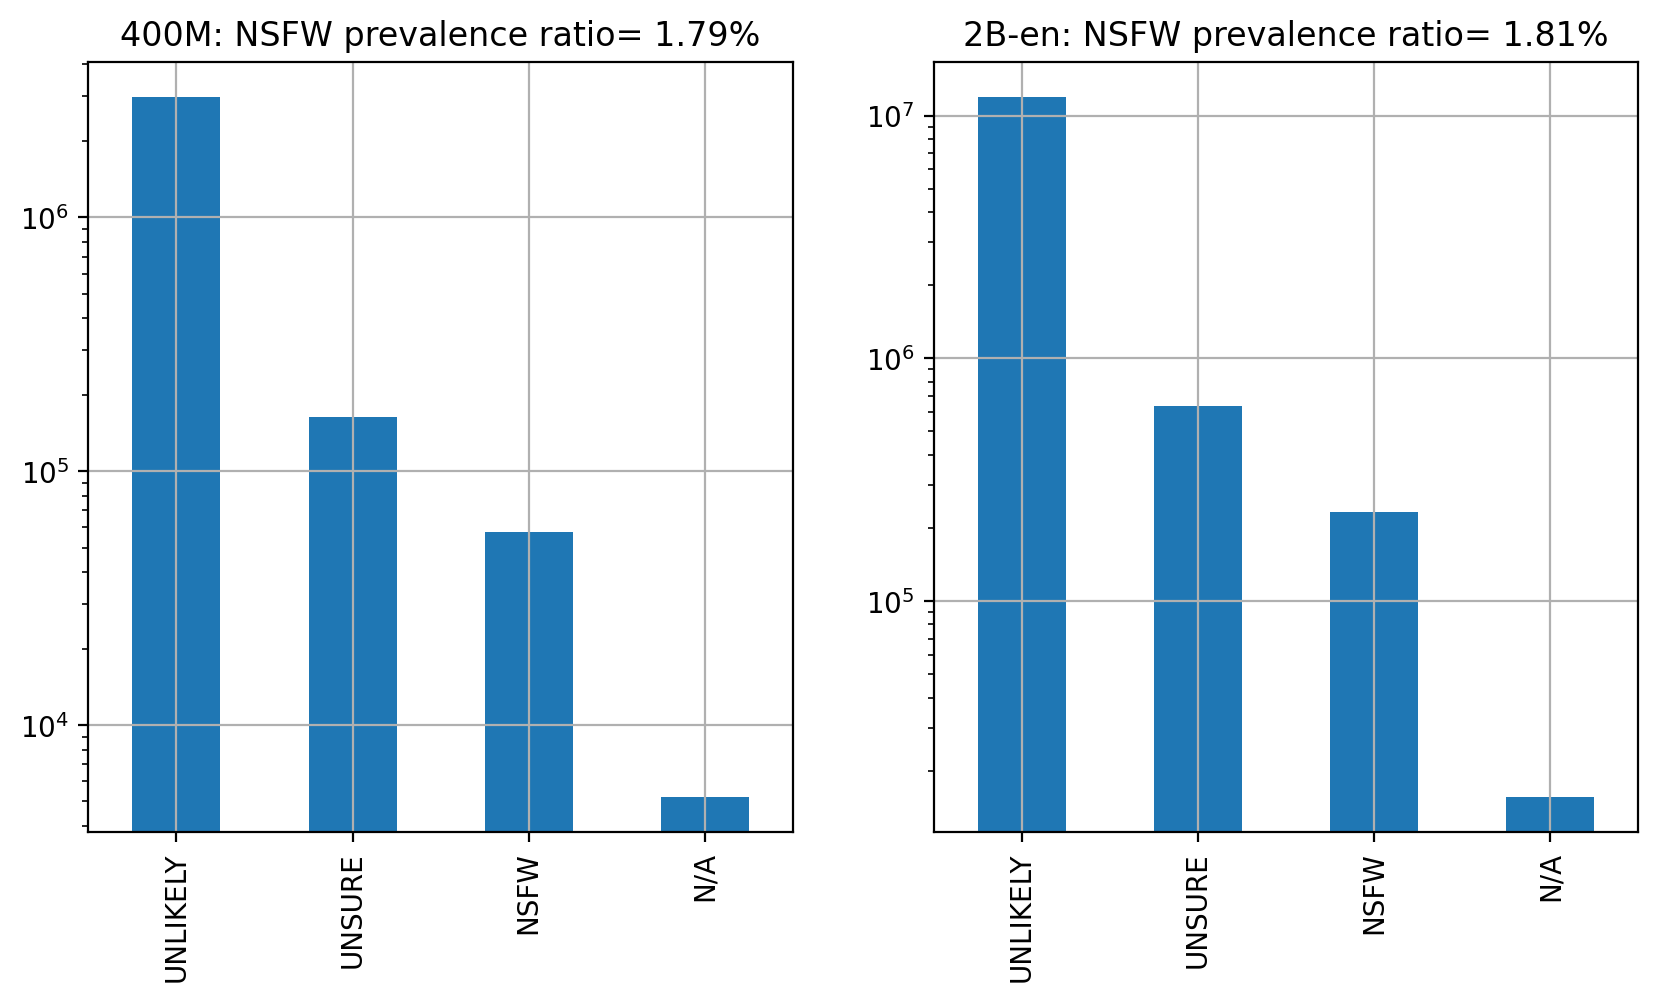

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
pd.Series(nsfw_400m).value_counts().plot(kind='bar',logy=True)
p_nsfw_400m=(pd.Series(nsfw_400m).value_counts()['NSFW']/nsfw_400m.shape[0])*100
plt.title(f'400M: NSFW prevalence ratio= {p_nsfw_400m:.2f}%')
plt.grid('On')

plt.subplot(122)
pd.Series(nsfw_2b).value_counts().plot(kind='bar',logy=True)

p_nsfw_2b=(pd.Series(nsfw_2b).value_counts()['NSFW']/nsfw_2b.shape[0])*100
plt.title(f'2B-en: NSFW prevalence ratio= {p_nsfw_2b:.2f}%')
plt.grid('On')

## Q2: NSFW-Hate nexus:

- Let us assume a priori that an image is NSFW tagged. For simplicity, we focus on the binary scenario of the tags being [NSFW/UNLIKELY]
- Now, associated with these two classes are class-conditional distributions of hate-probability scores (Read 
$P(hate|tag \in \{'NSFW','UNLIKELY'\})$). 

Question: Are the class conditional distribution statitics (such as mean etc) different for the 400M and 2B datasets?

In [10]:
list_types=['P_hateful', 'P_targeted', 'P_aggressive']
df_400m=pd.DataFrame(columns=['NSFW']+list_types)
df_400m['NSFW']=nsfw_400m
df_400m.loc[:,list_types]=prob_hate_400m
df_400m.loc[:,'P_anyof3']=np.max(prob_hate_400m,axis=1)

df_400m


<ipython-input-10-d700cbe1d9f2>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_400m.loc[:,list_types]=prob_hate_400m


,NSFW,P_hateful,P_targeted,P_aggressive,P_anyof3
0,UNLIKELY,0.016579,0.010607,0.010686,0.016579
1,UNLIKELY,0.017069,0.010392,0.010770,0.017069
2,UNLIKELY,0.026940,0.016269,0.011164,0.026940
3,UNLIKELY,0.043660,0.012537,0.014100,0.043660
4,UNLIKELY,0.015439,0.012069,0.010701,0.015439
...,...,...,...,...,...
3199995,UNLIKELY,0.019480,0.010772,0.010887,0.019480
3199996,UNLIKELY,0.019823,0.011358,0.009828,0.019823
3199997,UNLIKELY,0.017180,0.011682,0.011102,0.017180
3199998,NSFW,0.015920,0.012443,0.010805,0.015920


In [11]:
df_2b=pd.DataFrame(columns=['NSFW']+list_types)
df_2b['NSFW']=nsfw_2b
df_2b.loc[:,list_types]=prob_hate_2b
df_2b.loc[:,'P_anyof3']=np.max(prob_hate_2b,axis=1)

df_2b

<ipython-input-11-4f8a0bc227e0>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_2b.loc[:,list_types]=prob_hate_2b


,NSFW,P_hateful,P_targeted,P_aggressive,P_anyof3
0,UNLIKELY,0.016469,0.009298,0.012265,0.016469
1,UNLIKELY,0.017578,0.011240,0.010119,0.017578
2,UNSURE,0.039892,0.011861,0.015441,0.039892
3,UNSURE,0.016823,0.008244,0.011551,0.016823
4,UNLIKELY,0.057168,0.029959,0.007619,0.057168
...,...,...,...,...,...
12799995,UNLIKELY,0.018310,0.011420,0.009967,0.018310
12799996,UNLIKELY,0.016487,0.010563,0.011285,0.016487
12799997,UNLIKELY,0.016979,0.010964,0.010519,0.016979
12799998,UNLIKELY,0.020034,0.013807,0.011053,0.020034


In [12]:
df_400m.groupby('NSFW').agg('mean').loc[['NSFW','UNLIKELY']]

,P_hateful,P_targeted,P_aggressive,P_anyof3
NSFW,,,,
NSFW,0.037366,0.021163,0.012215,0.037462
UNLIKELY,0.021879,0.012967,0.010866,0.021894


In [13]:
df_2b.groupby('NSFW').agg('mean').loc[['NSFW','UNLIKELY']]

,P_hateful,P_targeted,P_aggressive,P_anyof3
NSFW,,,,
NSFW,0.038815,0.021839,0.012791,0.03891
UNLIKELY,0.021844,0.012746,0.010940,0.02186


## Q3: Studying the nexus between a sample's alt-text description failing quality test and the sample's image being tagged as NSFW

Now, let us define 'QF' as a quality failure binary detector of the alt-text  failing the following quality check: ```P_anyof3>0.5```.
Will there be a substantial difference in ```P(QF='True' | NSFW='True')``` for the two datasets

In [14]:
df_400m['QF']=df_400m.P_anyof3>0.5
df_2b['QF']=df_2b.P_anyof3>0.5

print(pd.crosstab(df_400m.NSFW,df_400m.QF,normalize='index'))
pd.crosstab(df_2b.NSFW,df_2b.QF,normalize='index')

QF           False     True 
NSFW                        
N/A       0.998079  0.001921
NSFW      0.985283  0.014717
UNLIKELY  0.998183  0.001817
UNSURE    0.979896  0.020104


QF,False,True
NSFW,,
N/A,0.998329,0.001671
NSFW,0.982666,0.017334
UNLIKELY,0.998119,0.001881
UNSURE,0.972274,0.027726


Text(0, 0.5, "P(QF='True' | NSFW='True')")

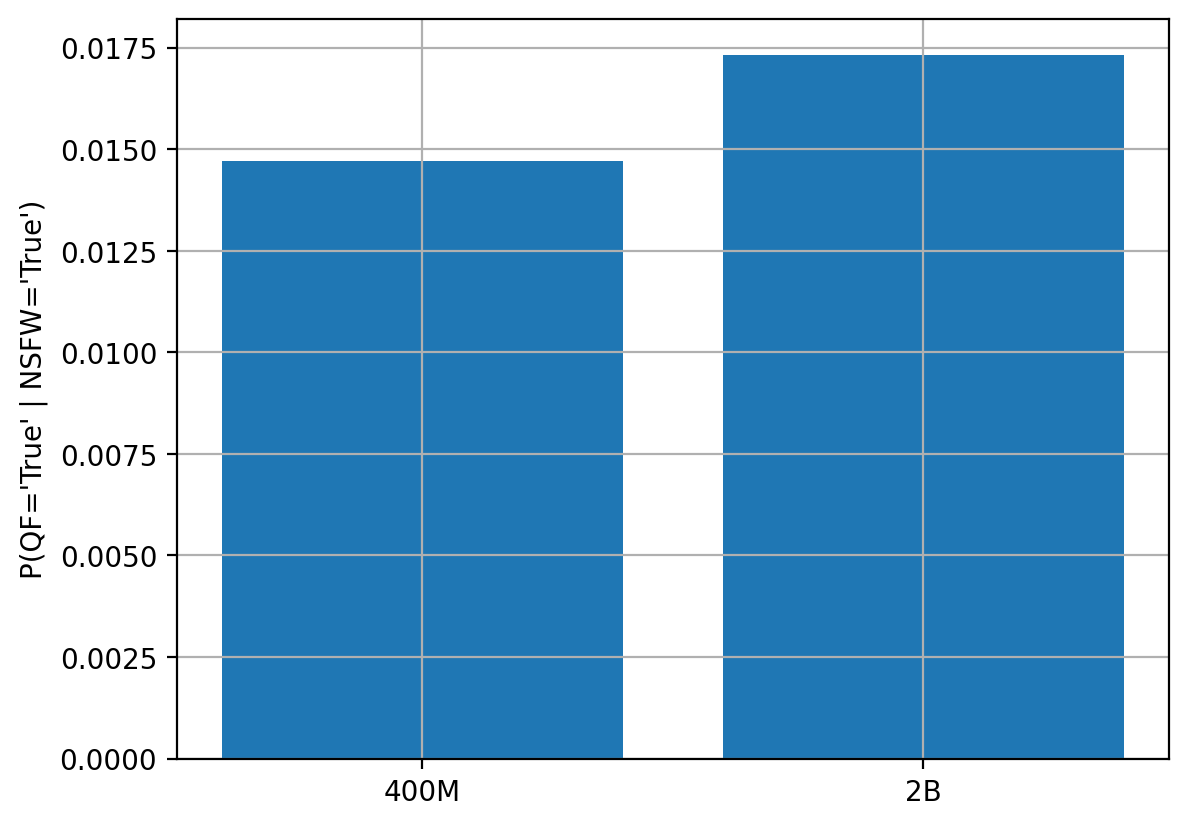

In [15]:
plt.bar([0,1],[pd.crosstab(df_400m.NSFW,df_400m.QF,normalize='index').loc['NSFW',:].values[1],
         pd.crosstab(df_2b.NSFW,df_2b.QF,normalize='index').loc['NSFW',:].values[1]])
plt.xticks([0,1],['400M','2B']);
plt.grid('On')
plt.ylabel("P(QF='True' | NSFW='True')")